## 一、计算最速曲线

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from datetime import datetime

import sys
sys.path.append("D:\Python\Jupyter_Code")
from utils import excelTools

from parameters import *

In [2]:
sub_dist = np.array(sub_dist)
station_idx = [np.where(sub_dist==each_station)[0].tolist()[0] for each_station in station_a_distance]
station_idx

[0, 267, 398, 639, 840, 941, 1097, 1226, 1363, 1601, 1829, 2040, 2171, 2307]

### 1. minitime: forward + calculation

In [14]:
def aCheck(a0, a1):
    delta_a = 0.6
    # 范围限制
    a1 = min(a1, MAX_ACC)
    # 变化率限制
    if a1 >= a0:
        a1 = min(a1, a0+delta_a)
    elif a1 < a0:
        a1 = max(a1, a0-delta_a)
        
    # 范围再次限制
    a1 = min(a1, MAX_ACC)

    return a1

def dvdx1(v, x, a0, sub_idx, state):
    if state == 'Tr':
        a1 = (f_t(v)-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif state == 'Cr':
        a1 = 0
    elif state == 'Co':
        a1 = (0-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif state == 'Br':
        a1 = (-f_b(v)-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    # aCheck
    a1 = aCheck(a0, a1)

    return a1 / v

def URTForward(v0, a0, sub_idx, state, dx):
    if state == 'Tr':
        a1 = (f_t(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif state == 'Cr':
        a1 = 0
    elif state == 'Co':
        a1 = (0-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif state == 'Br':
        a1 = (-f_b(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    # aCheck
    a1 = aCheck(a0, a1)

    x = np.arange(sub_dist[sub_idx], sub_dist[sub_idx+1]+dx, dx)
    v1 = odeint(func=dvdx1, y0=v0, t=x, args=(a0, sub_idx, state))

    return a1, v1, x

In [4]:
URTForward(0.01, 0, 1, 0, 'Tr', 1)

(0.6,
 array([[0.01      ],
        [1.09549066],
        [1.54922557],
        [1.89739294],
        [2.19091306],
        [2.44951018],
        [2.68330024],
        [2.89829265],
        [3.09840287],
        [3.28635062],
        [3.46411612]]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [26]:
#### forward #### 值得注意的是：在前向过程中计算的a, t, ener, f_t是不准确的，只有s, v是准确的

""" 变量初始值定义 """
INIT_IDX = 0  # 初始索引
INIT_TIME = 0  # 初始时间
INIT_S = 0  # 初始位置
INIT_VELO = 1e-10  # 初始速度
INIT_A = 0  # 初始加速度
INIT_FT = 0  # 初始牵引力
INIT_FB = 0  # 初始制动力
INIT_ENER = 0  # 初始化能量消耗

train1 = Train()
train1.clear()
train1.listExpand(float('nan'))

idx = INIT_IDX
train1.idx[0] = INIT_IDX
train1.t[0] = INIT_TIME
train1.s[0] = INIT_S
train1.v[0] = INIT_VELO
train1.a[0] = INIT_A
train1.f_t[0] = INIT_FT
train1.f_b[0] = INIT_FB
train1.e[0] = INIT_ENER

# section = np.array(section)
# station_1_idx = np.where(section==station_a_distance[0])  # sub_dist[267] = 2631 => station_1的位置

sub_dist = np.array(sub_dist)
station_idx = [np.where(sub_dist==each_station)[0].tolist()[0] for each_station in station_a_distance]

start_time = datetime.now()
for i in range(len(station_a_distance)-1):  # 全站的前向过程
    for j in range(station_idx[i+1]-station_idx[i]):
        # 索引、仿真步数更新
        idx += 1
        train1.listExpand(float('nan')) 
        train1.idx[idx] = idx
        sub_idx = station_idx[i]+ j  # 当前subsection的idx
        dx = 1
        _1_vlist, frlist = [], []

        train1.a[idx], vlist, xlist = URTForward(train1.v[idx-1], train1.a[idx-1], sub_idx, 'Tr', dx)
        train1.v[idx] = vlist[-1][0]

        if train1.v[idx] <= sub_spdlim[sub_idx]:
            for v in vlist:
                _1_vlist.append(1/v[0])
                frlist.append(f_b_r(v[0]))

        elif train1.v[idx] > sub_spdlim[sub_idx]:
            train1.v[idx] = sub_spdlim[sub_idx]
            train1.a[idx] = (sub_spdlim[sub_idx]**2-train1.v[idx-1]**2) / 2*sub_len[sub_idx]

            vlist = np.linspace(train1.v[idx-1], sub_spdlim[sub_idx], len(xlist))
            for v in vlist:
                _1_vlist.append(1/v)
                frlist.append(f_b_r(v))

        train1.s[idx] =  train1.s[idx-1] + sub_len[sub_idx]

        if train1.v[idx-1] < 1:
            delta_t = ((2*dx/(vlist[0]+vlist[1])) + np.trapz(_1_vlist[1:], x=xlist[1:])).item()
        else:
            delta_t = (np.trapz(_1_vlist, x=xlist)).item()
        train1.t[idx] = train1.t[idx-1] + delta_t

        if abs(train1.a[idx]) > 1:
             train1.a[idx] = 0
        train1.f_t[idx] = (MASS*train1.a[idx] + (f_b_r(train1.v[idx-1])+f_b_r(train1.v[idx]))/2 + f_a_r(sub_gradient[sub_idx]))

        e_fr = np.trapz(frlist, xlist)
        delta_e = 0.5*MASS*train1.v[idx]**2 - 0.5*MASS*train1.v[idx-1]**2 + abs(e_fr) + f_a_r(sub_gradient[sub_idx])*sub_len[sub_idx]
        train1.e[idx] =  train1.e[idx-1] + delta_e

    train1.a[idx] = 0 
    train1.v[idx] = 1e-10 

end_time = datetime.now()
print("for循环消耗时间：", (end_time - start_time).total_seconds(), "秒")
print(train1.t[-1])


for循环消耗时间： 1.02825 秒
1259.5147158110535


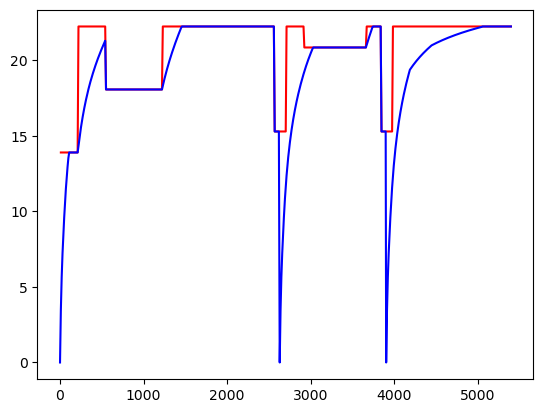

In [27]:
plt.plot(train1.s[1:550], sub_spdlim[0:549], color='r')
plt.plot(train1.s[0:550], train1.v[0:550], color='b')

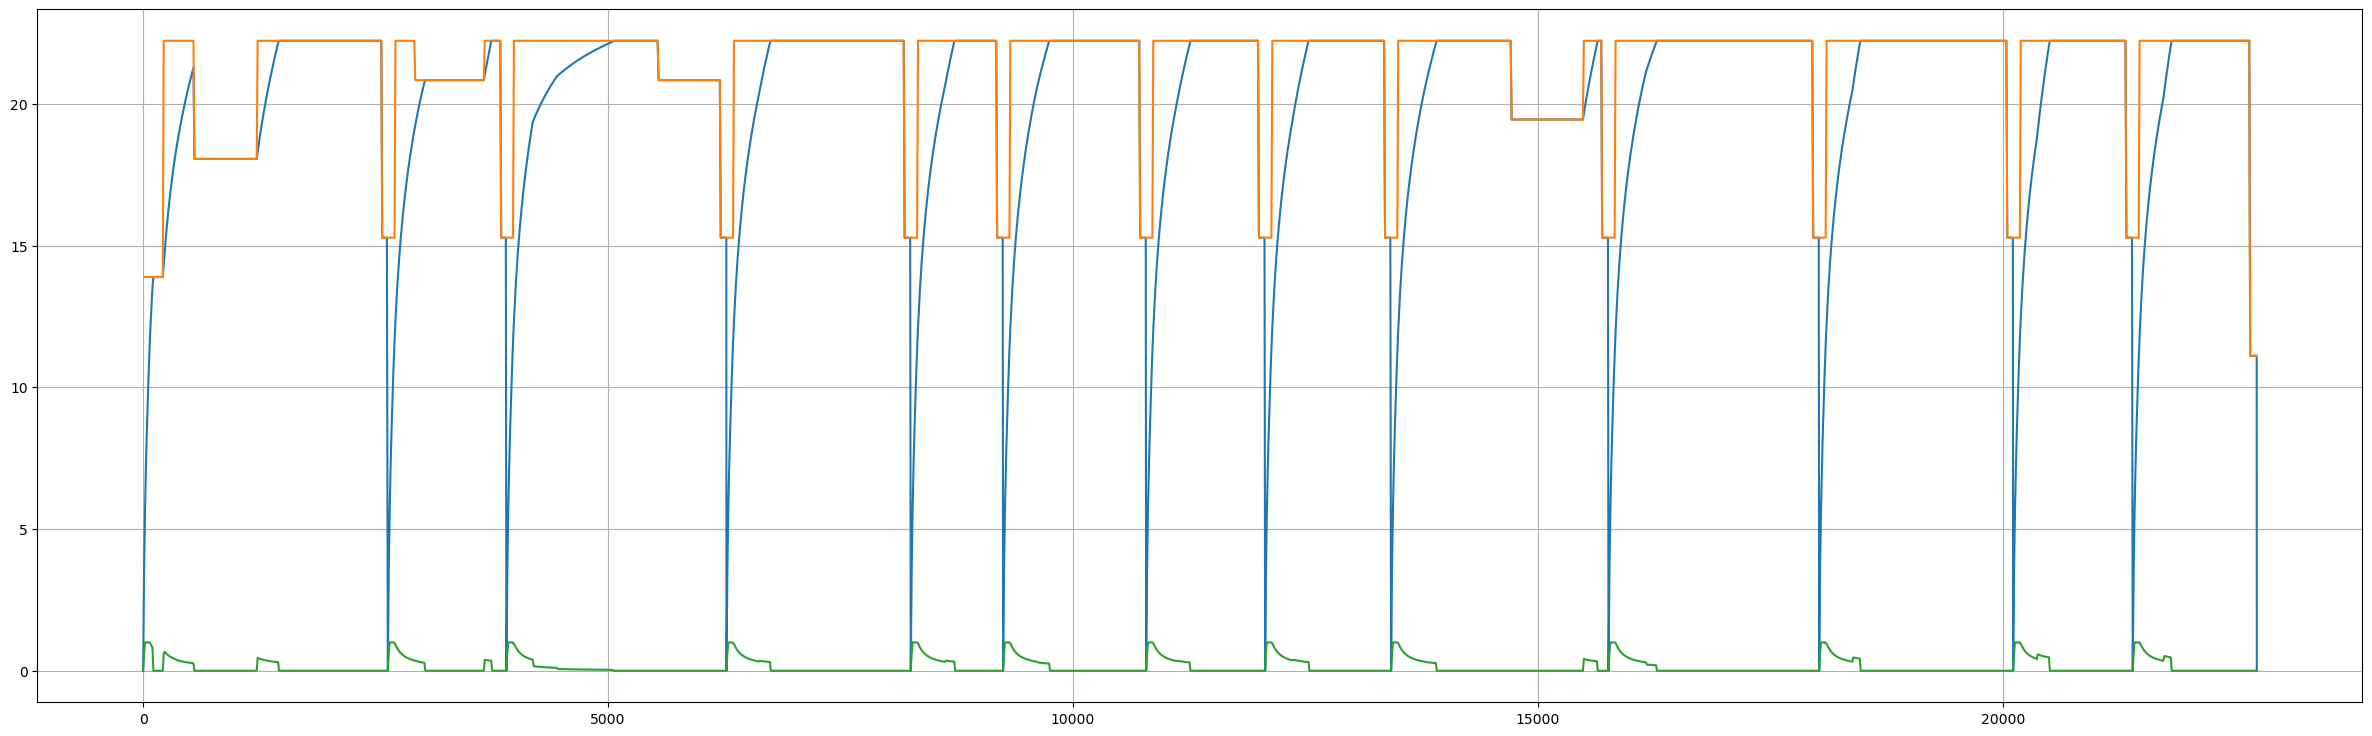

In [92]:
plt.figure(figsize=(30, 9))
plt.plot(train1.s, train1.v) 
# plt.scatter(train1.idx, train1.v, 2, 'r')
plt.plot(train1.s[1:], sub_spdlim)
plt.grid()
plt.plot(train1.s, train1.a)

In [93]:
# minitime + 数据存储
i = 10
column_names = [f'For ds={i} t', f'For ds={i} s', f'For ds={i} v', f'For ds={i} a', f'For ds={i} f', f'For ds={i} e']
data = {column_names[0]: train1.t,
        column_names[1]: train1.s,
        column_names[2]: train1.v,
        column_names[3]: train1.a,
        column_names[4]: train1.f_t,
        column_names[5]: train1.e}
excel_filepath = 'D:\Python\Jupyter_Code\CASCO\paper2\\results\minitime_10.xlsx' 
excelTools.dfStorage(data, excel_filepath, 1)

successful storage in D:\Python\Jupyter_Code\CASCO\paper2\results\minitime_10.xlsx


### 2. minitime: backward - calculation

In [31]:
re_section = section[::-1]
re_sub_num = sub_num[::-1]
re_sub_dist = sub_dist[::-1]
re_sub_len = sub_len[::-1]
re_sub_spdlim = sub_spdlim[::-1]
re_station_idx = station_idx[::-1]
re_station_idx 

[2307, 2171, 2040, 1829, 1601, 1363, 1226, 1097, 941, 840, 639, 398, 267, 0]

In [77]:
def dvdx2(v, x, a0, re_sub_idx, state):
    if state == 'Br':
        a1 = (f_b(v)+f_b_r(v)+f_a_r(sub_gradient[sub_idx])) / MASS
    a1 = aCheck(a0, a1)

    return a1 / v

def URTBackward(v0, a0, re_sub_idx, state, dx):
    if state == 'Br':
        a1 = (f_b(v0)+f_b_r(v0)+f_a_r(sub_gradient[re_sub_idx])) / MASS

    a1 = aCheck(a0, a1)
    x = np.arange(sub_dist[re_sub_idx], sub_dist[re_sub_idx+1]+dx, dx)
    v1 = odeint(func=dvdx2, y0=v0, t=x, args=(a0, re_sub_idx, state))

    return a1, v1, x

In [78]:
URTBackward(1e-10, 0, 2306, 'Br', 1)

(0.6,
 array([[1.00000000e-10],
        [1.09544502e+00]]),
 array([22727., 22728.]))

In [88]:
station_a_distance[13]

22728.0

In [89]:
#### backward ####

train2 = Train()

re_section = section[::-1]
re_sub_num = sub_num[::-1]
re_sub_dist = sub_dist[::-1]
re_sub_len = sub_len[::-1]
re_sub_spdlim = sub_spdlim[::-1]
re_station_idx = station_idx[::-1]
# reverse_sub_spdlim.insert(0,40/3.6)

""" 变量初始值定义 """
INIT_IDX = 0  # 初始索引
INIT_TIME = 0  # 初始时间
INIT_S = station_a_distance[13]  # 初始位移 22728 m
INIT_VELO = 1e-10  # 初始速度
INIT_A = 0  # 初始加速度
INIT_FT = 0  # 初始牵引力
INIT_FB = 0  # 初始制动力
INIT_ENER = 0  # 初始化能量消耗

train2.clear()
train2.listExpand(float('nan'))

idx = INIT_IDX
train2.idx[0] = INIT_IDX
train2.t[0] = INIT_TIME
train2.s[0] = INIT_S
train2.v[0] = INIT_VELO
train2.a[0] = INIT_A
train2.f_t[0] = INIT_FT
train2.f_b[0] = INIT_FB
train2.e[0] = INIT_ENER


start_time = datetime.now()
for i in range(len(station_a_distance)-1):
    for j in range(re_station_idx[i]-re_station_idx[i+1]):
        idx += 1
        train2.listExpand(float('nan'))
        train2.idx[idx] = idx
        re_sub_idx = re_station_idx[i] - j - 1  # -1是因为len(sub_dist)-len(sub_len)=1
        dx = 1
        _1_vlist = []

        train2.a[idx], vlist, xlist = URTBackward(train2.v[idx-1], train2.a[idx-1], re_sub_idx, 'Br', dx)
        train2.v[idx] = vlist[-1][0]

        if train2.v[idx] <= sub_spdlim[re_sub_idx]:
            for v in vlist:
                _1_vlist.append(1/v[0])

        elif train2.v[idx] > sub_spdlim[re_sub_idx]:
            train2.v[idx] = sub_spdlim[re_sub_idx]
            train2.a[idx] = (train2.v[idx]**2-train2.v[idx-1]**2) / 2*sub_len[re_sub_idx]
            # print(train2.a[idx])
            if abs(train2.a[idx]) > 1:
                train2.a[idx] = 0
                
            vlist = np.linspace(train2.v[idx-1], sub_spdlim[re_sub_idx], len(xlist))
            for v in vlist:
                _1_vlist.append(1/v)

        train2.s[idx] = train2.s[idx-1] - sub_len[re_sub_idx]

        if train2.v[idx-1] < 1:
            delta_t = ((2*dx/(vlist[0]+vlist[1])) + np.trapz(_1_vlist[1:], xlist[1:])).item()
        else:
            delta_t = (np.trapz(_1_vlist, xlist)).item()

        train2.t[idx] = train2.t[idx-1] + delta_t
    
    train2.v[idx] = 1e-10
    train2.a[idx] = 0

end_time = datetime.now()
print("for循环消耗时间: ", (end_time - start_time).total_seconds(), "秒")
print(train1.t[-1])


for循环消耗时间:  0.936887 秒
1259.5147158110535


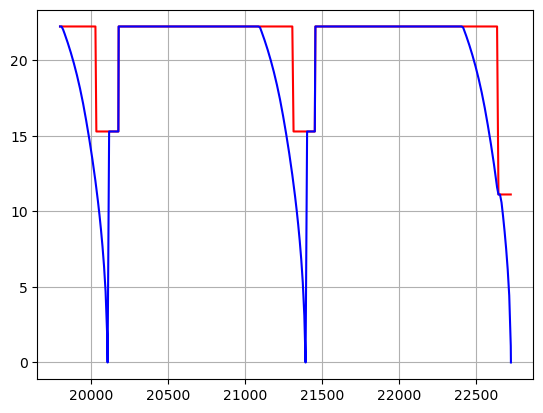

In [90]:
plt.plot(re_sub_dist[1:300], re_sub_spdlim[0:299], color='r')
plt.plot(train2.s[0:300], train2.v[0:300], color='b')
plt.grid()

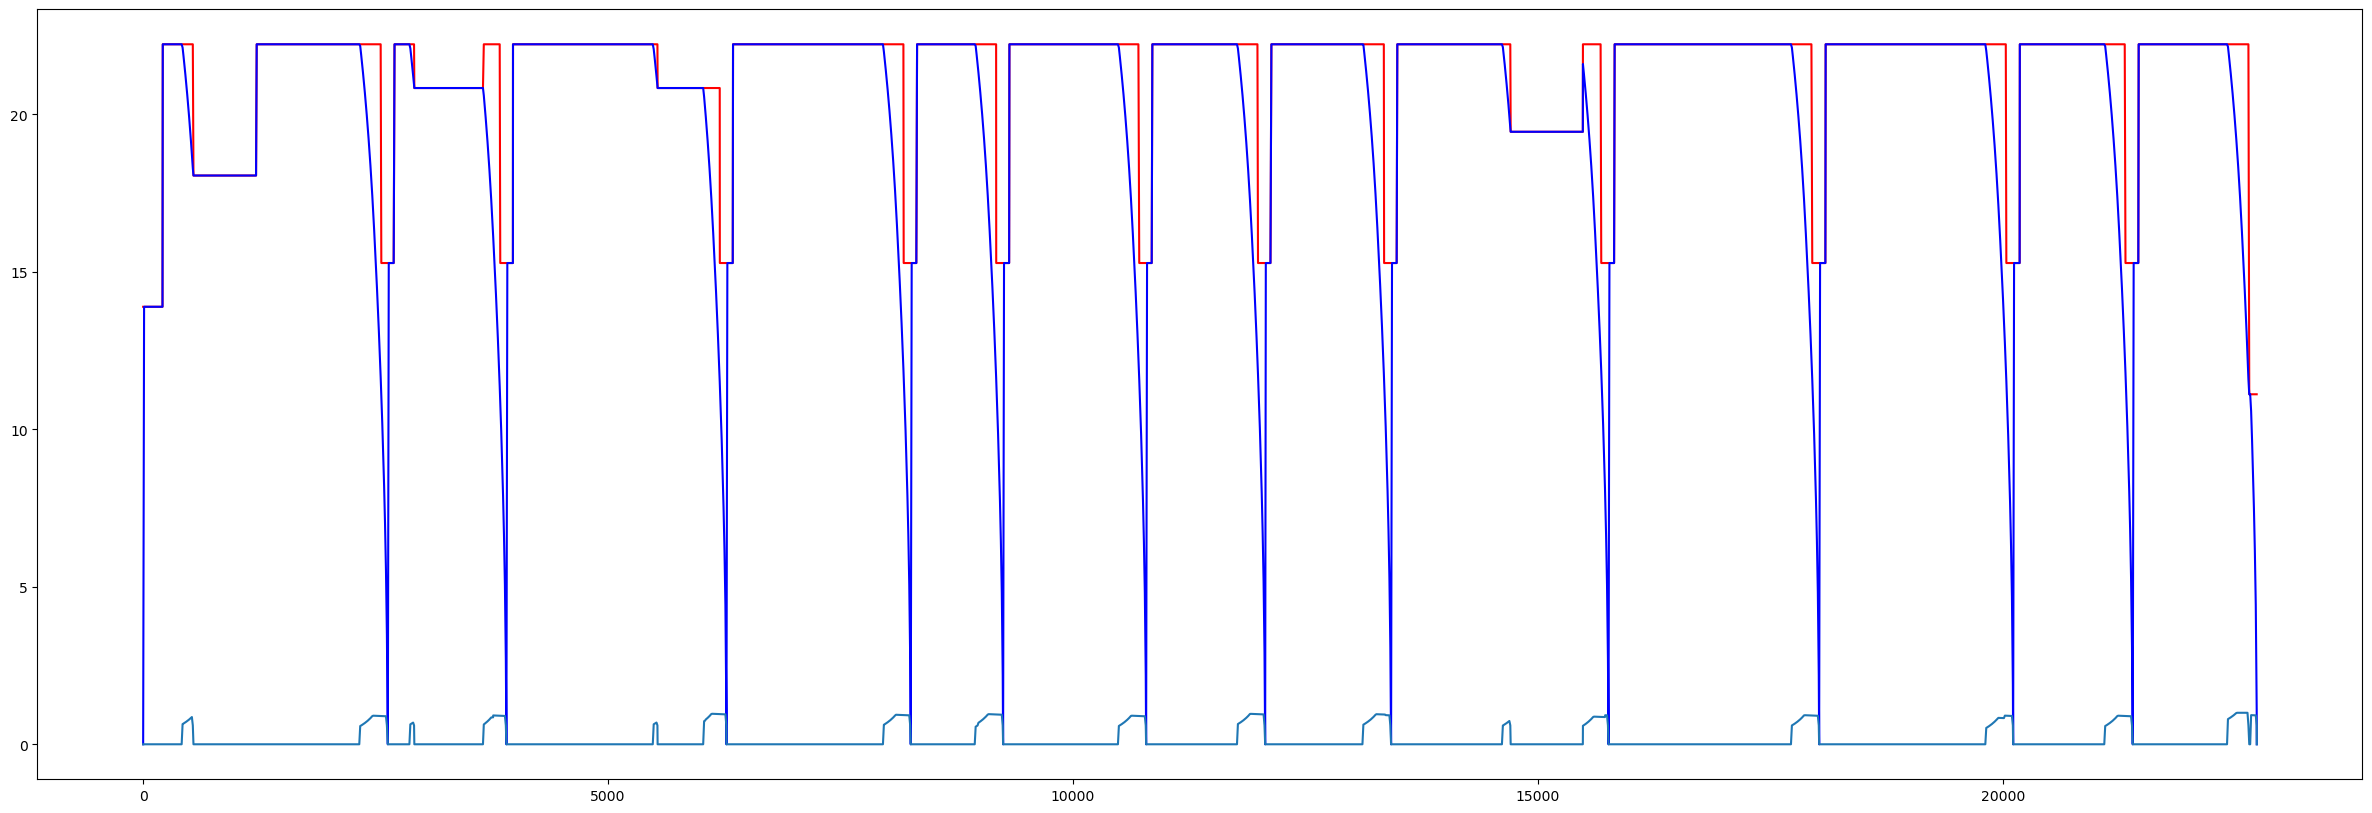

In [94]:
plt.figure(figsize=(30, 10))
plt.plot(train2.s[1:], re_sub_spdlim, 'r')
plt.plot(train2.s, train2.v, 'b')
plt.plot(train2.s, train2.a)

In [96]:
# ds=5 + 数据存储
i = 10
column_names = [f'Back ds={i} t', f'Back ds={i} s', f'Back ds={i} v', f'Back ds={i} a', f'Back ds={i} f', f'Back ds={i} e']
data = {column_names[0]: train2.t,
        column_names[1]: train2.s,
        column_names[2]: train2.v,
        column_names[3]: train2.a,
        column_names[4]: train2.f_t,
        column_names[5]: train2.e}
excel_filepath = 'D:\Python\Jupyter_Code\CASCO\paper2\\results\minitime_10.xlsx' 
excelTools.dfStorage(data, excel_filepath, 2)

successful storage in D:\Python\Jupyter_Code\CASCO\paper2\results\minitime_10.xlsx


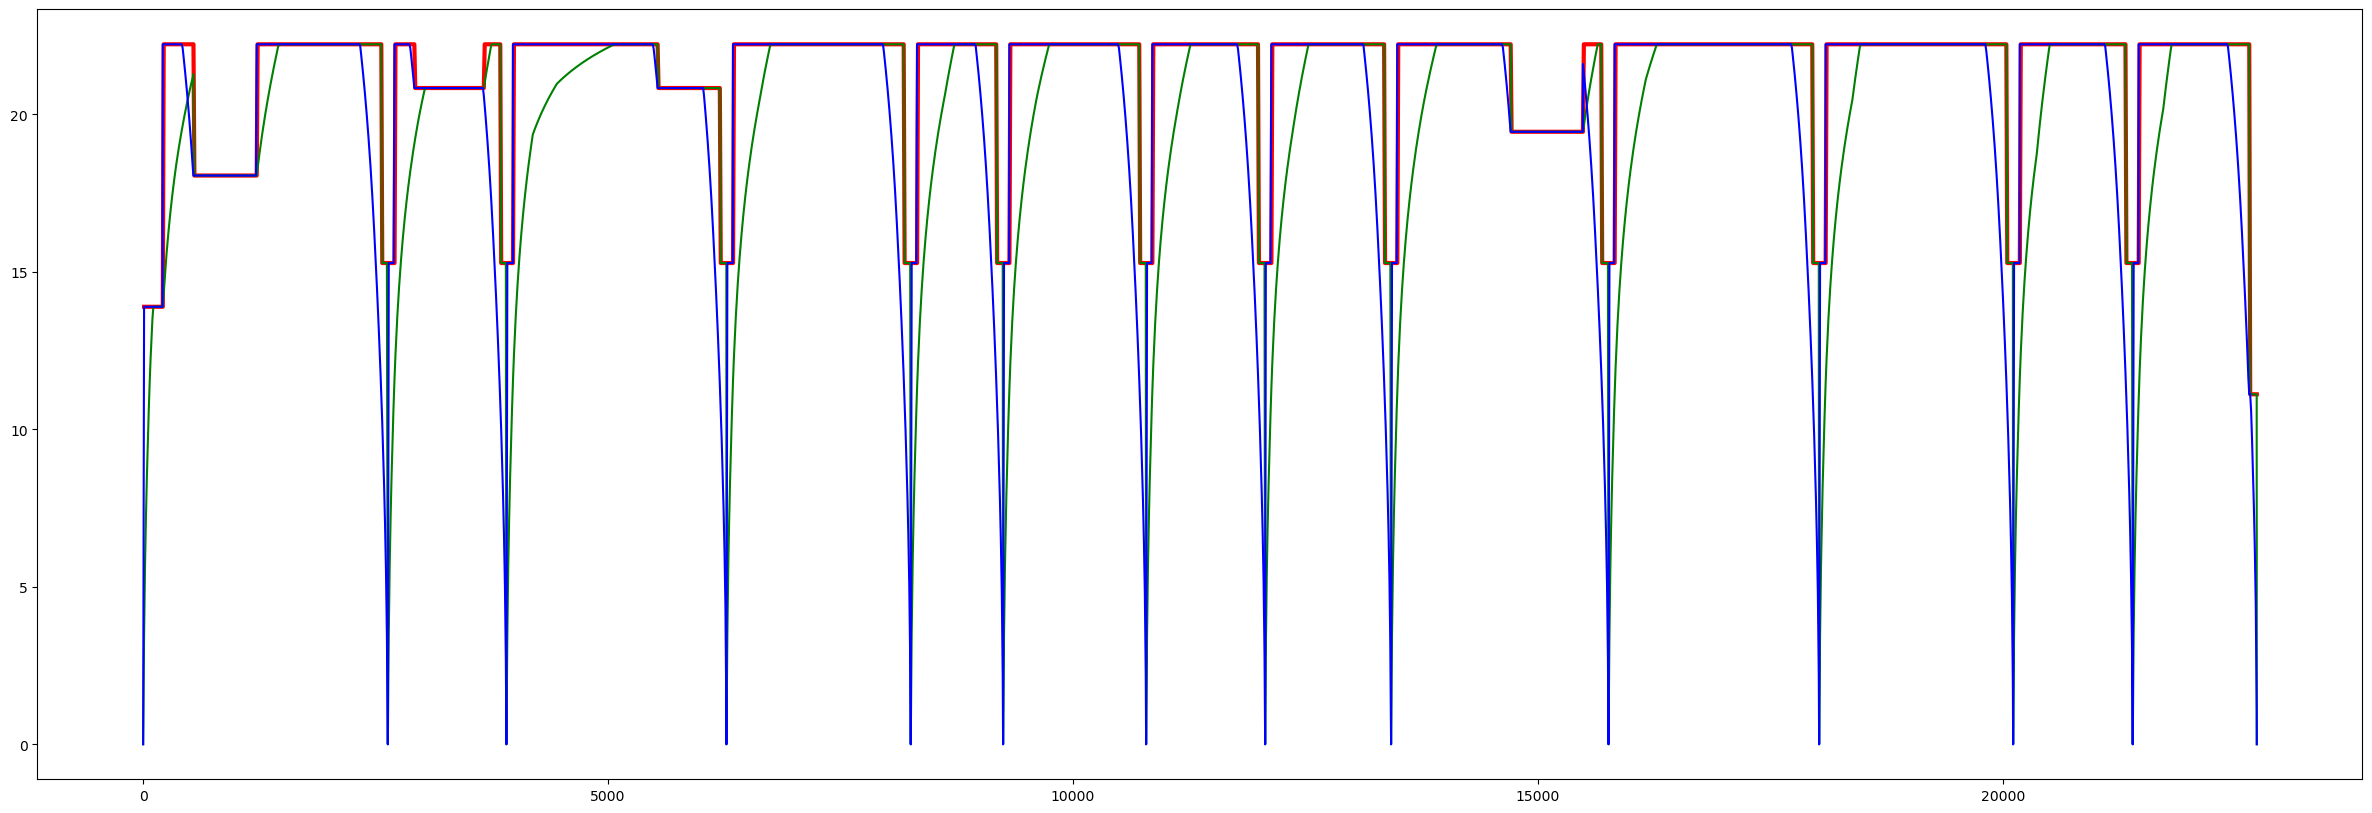

In [97]:
plt.figure(figsize=(30, 10))
plt.plot(sub_dist[1:], sub_spdlim, color='r', linewidth=3)
plt.plot(train1.s, train1.v, color='g')
plt.plot(train2.s, train2.v, color='b')

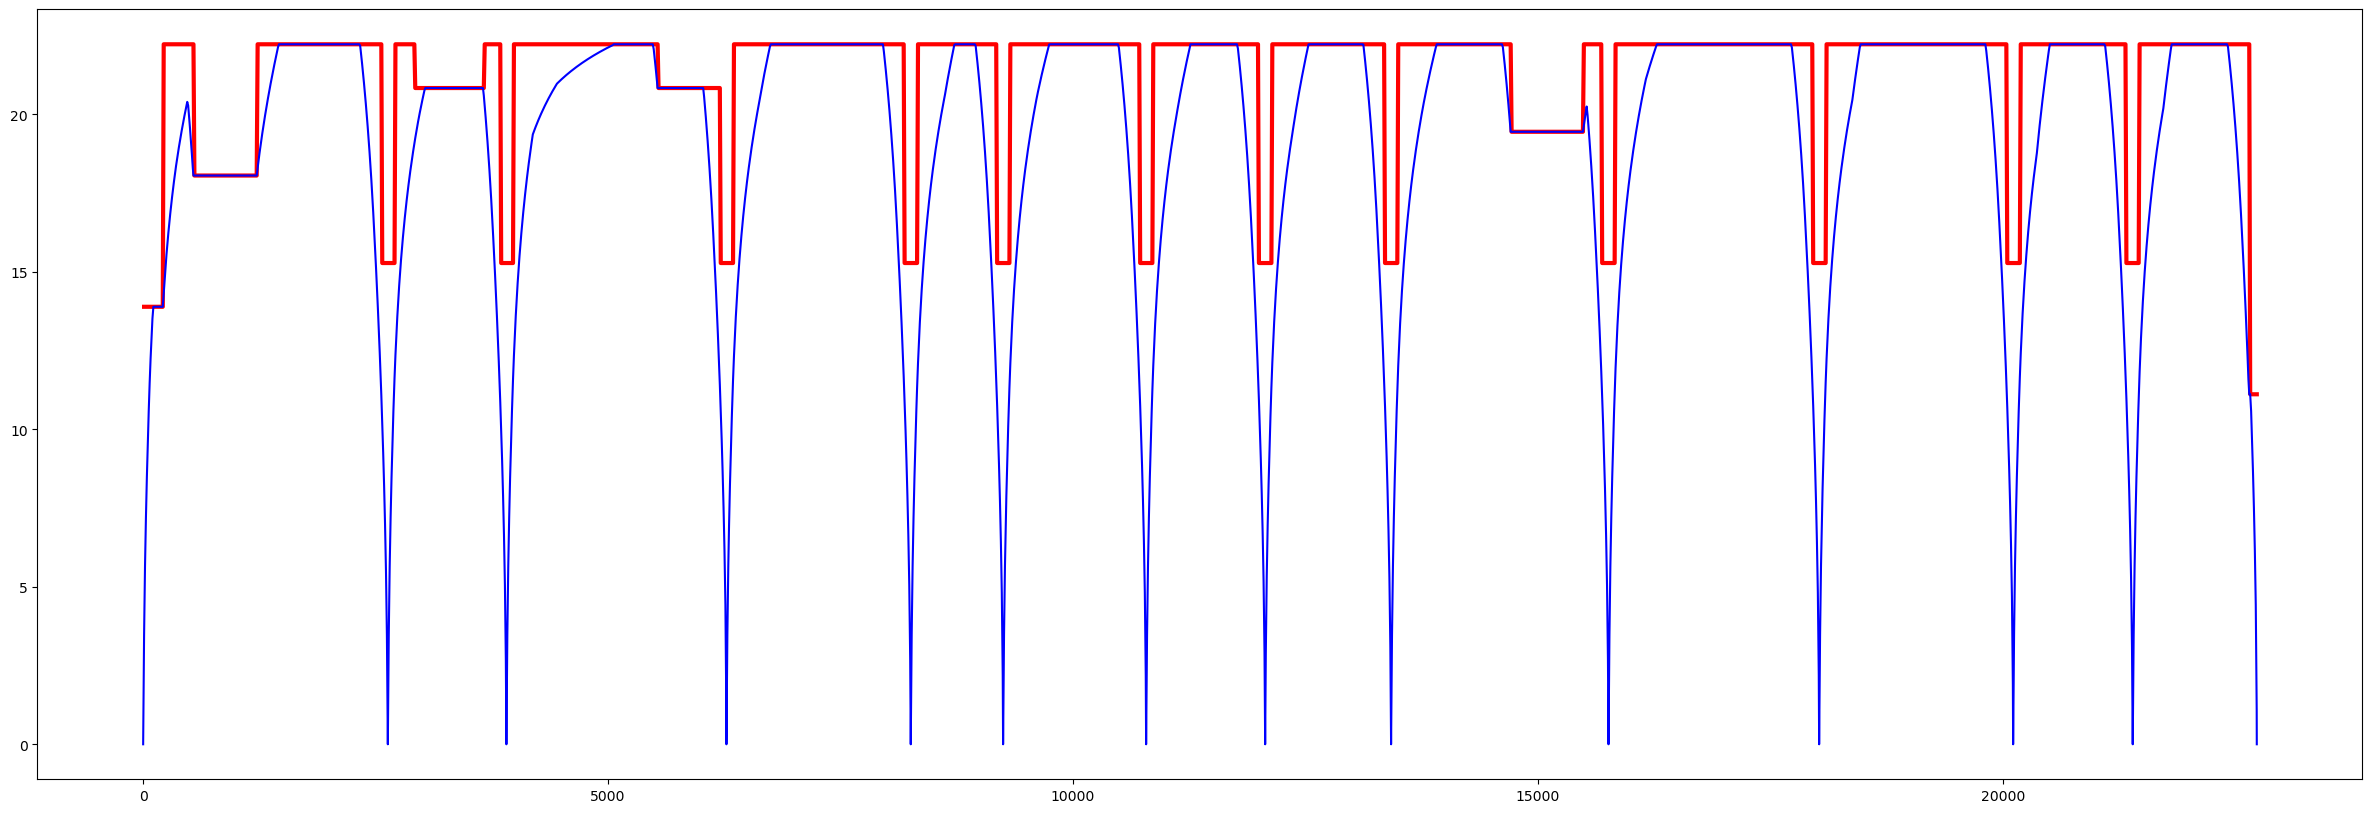

In [98]:
# 合并
mini_time = {key: min(v1, v2) for key, v1, v2 in zip(train1.s, train1.v, train2.v[::-1])}
s_keys, v_values = zip(*mini_time.items())
plt.figure(figsize=(30, 10))
plt.plot(sub_dist[1:], sub_spdlim, color='r', linewidth=3)
plt.plot(s_keys, v_values, color='b')

In [99]:
# minitime - 数据存储
column_names = ['whole ds=10 s', 'whole ds=10 v']
data = {column_names[0]: s_keys,
        column_names[1]: v_values}

excel_filepath = 'D:\Python\Jupyter_Code\CASCO\paper2\\results\minitime_10.xlsx'
excelTools.dfStorage(data, excel_filepath, 3)

successful storage in D:\Python\Jupyter_Code\CASCO\paper2\results\minitime_10.xlsx


In [100]:
# 字体调整
excelTools.fontSet(excel_filepath)